# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
from pymongo import MongoClient as mc
from bson import ObjectId
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import time
import json
import os
import folium   
from folium.plugins import MarkerCluster
from gensim import corpora
from gensim.models import LdaModel
from wordcloud import WordCloud
import random

# Reading the data

In [2]:
job_posting = pd.read_csv("../data/LinkedIn_Jobs/linkedin_job_postings.csv")
job_posting.head()

job_link  \
0  https://www.linkedin.com/jobs/view/account-exe...   
1  https://www.linkedin.com/jobs/view/registered-...   
2  https://www.linkedin.com/jobs/view/restaurant-...   
3  https://www.linkedin.com/jobs/view/independent...   
4  https://www.linkedin.com/jobs/view/group-unit-...   

             last_processed_time got_summary got_ner is_being_worked  \
0   2024-01-21 07:12:29.00256+00           t       t               f   
1   2024-01-21 07:39:58.88137+00           t       t               f   
2  2024-01-21 07:40:00.251126+00           t       t               f   
3  2024-01-21 07:40:00.308133+00           t       t               f   
4  2024-01-19 09:45:09.215838+00           f       f               f   

                                           job_title  \
0  Account Executive - Dispensing (NorCal/Norther...   
1                 Registered Nurse - RN Care Manager   
2               RESTAURANT SUPERVISOR - THE FORKLIFT   
3                      Independent Real Estate Agent   
4  Group/Unit Supervisor (Systems Support Manager...   

                        company          job_location  first_seen  \
0                            BD         San Diego, CA  2024-01-15   
1             Trinity Health MI     Norton Shores, MI  2024-01-14   
2       Wasatch Adaptive Sports             Sandy, UT  2024-01-14   
3    Howard Hanna | Rand Realty  Englewood Cliffs, NJ  2024-01-16   
4  IRS, Office of Chief Counsel          Chamblee, GA  2024-01-17   

   search_city search_country                       search_position  \
0     Coronado  United States                           Color Maker   
1  Grand Haven  United States              Director Nursing Service   
2       Tooele  United States                              Stand-In   
3    Pinehurst  United States                     Real-Estate Clerk   
4      Gadsden  United States  Supervisor Travel-Information Center   

    job_level job_type  
0  Mid senior   Onsite  
1  Mid senior   Onsite  
2  Mid senior   Onsite  
3  Mid senior   Onsite  
4  Mid senior   Onsite

In [3]:
job_summary = pd.read_csv("../data/LinkedIn_Jobs/job_summary.csv")
job_summary.head()

job_link  \
0  https://www.linkedin.com/jobs/view/restaurant-...   
1  https://www.linkedin.com/jobs/view/med-surg-re...   
2  https://www.linkedin.com/jobs/view/registered-...   
3  https://uk.linkedin.com/jobs/view/commercial-a...   
4  https://www.linkedin.com/jobs/view/store-manag...   

                                         job_summary  
0  Rock N Roll Sushi is hiring a Restaurant Manag...  
1  Schedule\n: PRN is required minimum 12 hours p...  
2  Description\nIntroduction\nAre you looking for...  
3  Commercial account executive\nSheffield\nFull ...  
4  Address:\nUSA-CT-Newington-44 Fenn Road\nStore...

In [4]:
job_skills = pd.read_csv("../data/LinkedIn_Jobs/job_skills.csv")
job_skills.head()

job_link  \
0  https://www.linkedin.com/jobs/view/housekeeper...   
1  https://www.linkedin.com/jobs/view/assistant-g...   
2  https://www.linkedin.com/jobs/view/school-base...   
3  https://www.linkedin.com/jobs/view/electrical-...   
4  https://www.linkedin.com/jobs/view/electrical-...   

                                          job_skills  
0  Building Custodial Services, Cleaning, Janitor...  
1  Customer service, Restaurant management, Food ...  
2  Applied Behavior Analysis (ABA), Data analysis...  
3  Electrical Engineering, Project Controls, Sche...  
4  Electrical Assembly, Point to point wiring, St...

#### We are expecting job link as a common column among all 3 csv files and may be joined based on that.

Lets try to confirm that..

In [5]:
print(f"Job Posting Shape: {job_posting.shape}")
print(f"Job Skills Shape{job_skills.shape}")
print(f"Job Summary Shape{job_summary.shape}")

Job Posting Shape: (1348454, 14)
Job Skills Shape(1296381, 2)
Job Summary Shape(1297332, 2)


#### Let us check if there are common job link present for 3 datasets

In [6]:
#converting each "job link" column into set of links
job_posting_links = set(job_posting["job_link"])
job_summary_links = set(job_summary["job_link"])
job_skills_links = set(job_skills["job_link"])

#find common links
common_links = job_posting_links & job_summary_links & job_skills_links

print(f"Total Jobs in Job Posting: {len(job_posting_links)}")
print(f"Total Jobs in Job Summary: {len(job_summary_links)}")
print(f"Total Jobs in Job Skills: {len(job_skills_links)}")
print(f"Total Jobs in common : {len(common_links)}")

Total Jobs in Job Posting: 1348454
Total Jobs in Job Summary: 1297332
Total Jobs in Job Skills: 1296381
Total Jobs in common : 1296381


So there are 1296381 common jobs present in all 3 dataset

Before the datasets are joined we need to check the data type of the features

In [7]:
job_posting.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348454 entries, 0 to 1348453
Data columns (total 14 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   job_link             1348454 non-null  object
 1   last_processed_time  1348454 non-null  object
 2   got_summary          1348454 non-null  object
 3   got_ner              1348454 non-null  object
 4   is_being_worked      1348454 non-null  object
 5   job_title            1348454 non-null  object
 6   company              1348443 non-null  object
 7   job_location         1348435 non-null  object
 8   first_seen           1348454 non-null  object
 9   search_city          1348454 non-null  object
 10  search_country       1348454 non-null  object
 11  search_position      1348454 non-null  object
 12  job_level            1348454 non-null  object
 13  job_type             1348454 non-null  object
dtypes: object(14)
memory usage: 144.0+ MB


In [8]:
job_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297332 entries, 0 to 1297331
Data columns (total 2 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   job_link     1297332 non-null  object
 1   job_summary  1297332 non-null  object
dtypes: object(2)
memory usage: 19.8+ MB


In [9]:
job_skills.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296381 entries, 0 to 1296380
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   job_link    1296381 non-null  object
 1   job_skills  1294296 non-null  object
dtypes: object(2)
memory usage: 19.8+ MB


Every feature is of object data type

# Joining 3 datasets

In [10]:
merged_df = job_posting.merge(job_summary, on="job_link", how="inner")
merged_df = merged_df.merge(job_skills, on="job_link", how="inner")

print(f"Merged DataFrame Shape: {merged_df.shape}")

Merged DataFrame Shape: (1296381, 16)


In [11]:
merged_df.head()

job_link  \
0  https://www.linkedin.com/jobs/view/account-exe...   
1  https://www.linkedin.com/jobs/view/registered-...   
2  https://www.linkedin.com/jobs/view/restaurant-...   
3  https://www.linkedin.com/jobs/view/independent...   
4  https://www.linkedin.com/jobs/view/registered-...   

             last_processed_time got_summary got_ner is_being_worked  \
0   2024-01-21 07:12:29.00256+00           t       t               f   
1   2024-01-21 07:39:58.88137+00           t       t               f   
2  2024-01-21 07:40:00.251126+00           t       t               f   
3  2024-01-21 07:40:00.308133+00           t       t               f   
4  2024-01-21 08:08:19.663033+00           t       t               f   

                                           job_title  \
0  Account Executive - Dispensing (NorCal/Norther...   
1                 Registered Nurse - RN Care Manager   
2               RESTAURANT SUPERVISOR - THE FORKLIFT   
3                      Independent Real Estate Agent   
4                              Registered Nurse (RN)   

                      company          job_location  first_seen  search_city  \
0                          BD         San Diego, CA  2024-01-15     Coronado   
1           Trinity Health MI     Norton Shores, MI  2024-01-14  Grand Haven   
2     Wasatch Adaptive Sports             Sandy, UT  2024-01-14       Tooele   
3  Howard Hanna | Rand Realty  Englewood Cliffs, NJ  2024-01-16    Pinehurst   
4           Trinity Health MI          Muskegon, MI  2024-01-14     Muskegon   

  search_country           search_position   job_level job_type  \
0  United States               Color Maker  Mid senior   Onsite   
1  United States  Director Nursing Service  Mid senior   Onsite   
2  United States                  Stand-In  Mid senior   Onsite   
3  United States         Real-Estate Clerk  Mid senior   Onsite   
4  United States        Nurse Practitioner  Mid senior   Onsite   

                                         job_summary  \
0  Responsibilities\nJob Description Summary\nJob...   
1  Employment Type:\nFull time\nShift:\nDescripti...   
2  Job Details\nDescription\nWhat You'll Do\nAs a...   
3  Who We Are\nRand Realty is a family-owned brok...   
4  Employment Type:\nFull time\nShift:\n12 Hour N...   

                                          job_skills  
0  Medical equipment sales, Key competitors, Term...  
1  Nursing, Bachelor of Science in Nursing, Maste...  
2  Restaurant Operations Management, Inventory Ma...  
3  Real Estate, Customer Service, Sales, Negotiat...  
4  Nursing, BSN, Medical License, Virtual RN, Nur...

In [12]:
# checking for null values
merged_df.isnull().sum()

job_link                  0
last_processed_time       0
got_summary               0
got_ner                   0
is_being_worked           0
job_title                 0
company                   9
job_location             19
first_seen                0
search_city               0
search_country            0
search_position           0
job_level                 0
job_type                  0
job_summary               0
job_skills             2085
dtype: int64

In [13]:
# dropping null values

merged_df.dropna(inplace=True)

# MongoDB Connection

In [4]:
# fetching database names

client = mc('mongodb://localhost:27017')
print(client.list_database_names())

['BigData', 'FavFruits', 'Fruit', 'Hospital', 'SIG', 'admin', 'config', 'dataanalysis', 'itemdb', 'local', 'sandip']


In [5]:
database = client['BigData']

In [6]:
# fetch collection names
print(database.list_collection_names())

['JobListings']


In [7]:
my_col = database['JobListings']

In [ ]:
# convert the dataframe to dictionaries and insert records

dictionaries = merged_df.to_dict(orient='records')
record_ids = my_col.insert_many(dictionaries)

In [63]:
# Get sample data

sample = my_col.find().limit(10)
for doc in sample:
    print(doc)

{'_id': ObjectId('67f3f53756f048df5c3e52f1'), 'job_link': 'https://www.linkedin.com/jobs/view/account-executive-dispensing-norcal-northern-nevada-becton-dickinson-at-bd-3802078767', 'last_processed_time': '2024-01-21 07:12:29.00256+00', 'is_being_worked': 'f', 'job_title': 'Account Executive - Dispensing (NorCal/Northern Nevada) - Becton Dickinson', 'company': 'BD', 'job_location': 'San Diego, CA', 'first_seen': '2024-01-15', 'search_city': 'Coronado', 'search_country': 'United States', 'search_position': 'Color Maker', 'job_level': 'Mid senior', 'job_type': 'Onsite', 'job_summary': "Responsibilities\nJob Description Summary\nJob Description\nWe are\nthe makers of possible\nBD is one of the largest global medical technology companies in the world. Advancing the world of health™ is our Purpose, and it’s no small feat. It takes the imagination and passion of all of us—from design and engineering to the manufacturing and marketing of our billions of MedTech products per year—to look at th

## Creating Indexes for faster retrieval of data

In [15]:
my_col.create_index("job_title")
my_col.create_index("job_location")
my_col.create_index("first_seen")

'first_seen_1'

In [21]:
# Others
my_col.create_index("search_city")
my_col.create_index("search_country")
my_col.create_index("job_type")
my_col.create_index("job_level")
my_col.create_index("company")


'company_1'

In [61]:
pprint(my_col.index_information())

{'_id_': {'key': [('_id', 1)], 'v': 2},
 'company_1': {'key': [('company', 1)], 'v': 2},
 'first_seen_1': {'key': [('first_seen', 1)], 'v': 2},
 'job_level_1': {'key': [('job_level', 1)], 'v': 2},
 'job_location_1': {'key': [('job_location', 1)], 'v': 2},
 'job_title_1': {'key': [('job_title', 1)], 'v': 2},
 'job_type_1': {'key': [('job_type', 1)], 'v': 2},
 'search_city_1': {'key': [('search_city', 1)], 'v': 2},
 'search_country_1': {'key': [('search_country', 1)], 'v': 2}}


# Exploratory Data Analysis

In [27]:
# Total number of Job Postings

job_count = my_col.count_documents({})
print("Total Job Postings: ", job_count)

Total Job Postings:  1294268


In [44]:
# got_summary analysis

pipeline = [{
    "$group": {
        "_id": "$got_summary",
        "count": {"$sum": 1}
    }
}]

print("Frequency of values in got_summary")
print("-" * 32)
for rec in list(my_col.aggregate(pipeline)):
    print(f"{rec['_id']}: {rec['count']}")

Frequency of values in got_summary
--------------------------------
t: 1294268


In [46]:
# got_ner analysis

pipeline = [{
    "$group": {
        "_id": "$got_ner",
        "count": {"$sum": 1}
    }
}]

print("Frequency of values in got_ner")
print("----------------------------------")
for rec in list(my_col.aggregate(pipeline)):
    print(f"{rec['_id']}: {rec['count']}")

Frequency of values in got_ner
----------------------------------
t: 1294268


In [47]:
# is_being_worked analysis

pipeline = [{
    "$group": {
        "_id": "$is_being_worked",
        "count": {"$sum": 1}
    }
}]

print("Frequency of values in is_being_worked")
print("----------------------------------")
for rec in list(my_col.aggregate(pipeline)):
    print(f"{rec['_id']}: {rec['count']}")

Frequency of values in is_being_worked
----------------------------------
f: 1294268


There is only 1 value in got_summary, got_ner, is_being_worked, so we can safely delete them as they are not adding value

In [64]:
# deleting got_summary, got_ner, is_being_worked fields from all documents

update_info = my_col.update_many({}, 
                                 {"$unset": 
                                  {"got_summary": "",
                                   "got_ner": "",
                                   "is_being_worked": ""}})

In [67]:
updated_count = update_info.modified_count
print("Number of documents updated: ", updated_count)

Number of documents updated:  1294268


Checking sample data keys to ensure changes

In [69]:
sample = my_col.aggregate([{"$sample": {"size": 5}}])

for rec in sample:
    pprint(rec.keys())

dict_keys(['_id', 'job_link', 'last_processed_time', 'job_title', 'company', 'job_location', 'first_seen', 'search_city', 'search_country', 'search_position', 'job_level', 'job_type', 'job_summary', 'job_skills'])
dict_keys(['_id', 'job_link', 'last_processed_time', 'job_title', 'company', 'job_location', 'first_seen', 'search_city', 'search_country', 'search_position', 'job_level', 'job_type', 'job_summary', 'job_skills'])
dict_keys(['_id', 'job_link', 'last_processed_time', 'job_title', 'company', 'job_location', 'first_seen', 'search_city', 'search_country', 'search_position', 'job_level', 'job_type', 'job_summary', 'job_skills'])
dict_keys(['_id', 'job_link', 'last_processed_time', 'job_title', 'company', 'job_location', 'first_seen', 'search_city', 'search_country', 'search_position', 'job_level', 'job_type', 'job_summary', 'job_skills'])
dict_keys(['_id', 'job_link', 'last_processed_time', 'job_title', 'company', 'job_location', 'first_seen', 'search_city', 'search_country', 'sea

Fields successfully deleted 

## Data Visualization

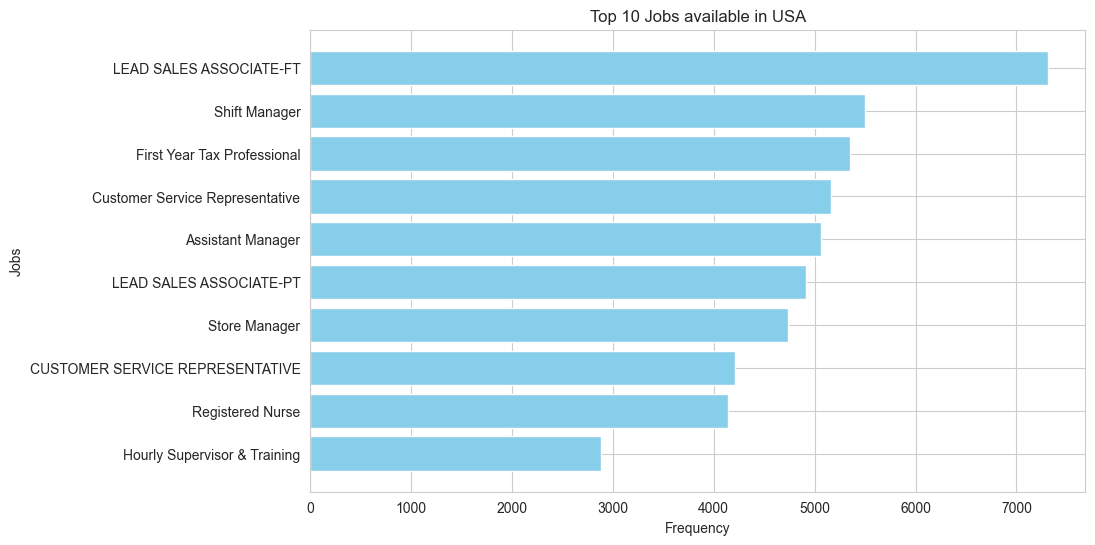

In [82]:
# Job Title

pipeline = [{
    "$group": {
        "_id": "$job_title",
        "count": {"$sum": 1}
    }},
    {"$sort": {'count': -1}},
    {"$limit": 10}]

result = list(my_col.aggregate(pipeline))

roles = [rec['_id'] for rec in result]
count = [rec['count'] for rec in result]

# Plotting
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
plt.barh(roles[::-1], count[::-1], color='skyblue')
plt.xlabel("Frequency")
plt.ylabel("Jobs")
plt.title("Top 10 Jobs available in USA")
plt.show()

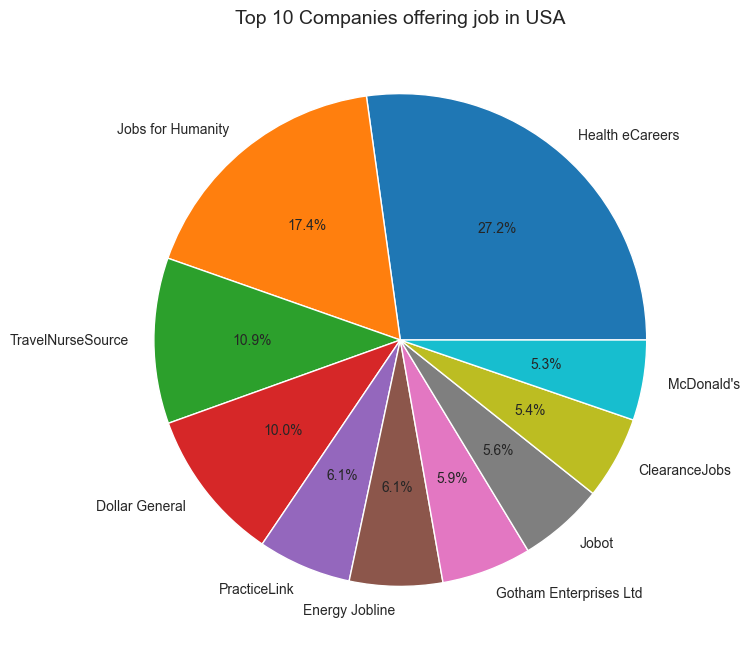

In [84]:
# companies offering most number of positions

pipeline = [{
    "$group": {
        '_id': "$company",
        'count': {'$sum': 1}
    }},
    {"$sort": {'count': -1}},
    {"$limit": 10}
    ]

result = list(my_col.aggregate(pipeline))

companies = [rec['_id'] for rec in result]
frequency = [rec['count'] for rec in result]

plt.figure(figsize=(8,8))
plt.pie(frequency, labels=companies, autopct='%1.1f%%')
plt.title("Top 10 Companies offering job in USA", fontsize=14)
plt.show()

In [8]:
pipeline = [{
    "$group": {
        "_id": "$job_location",
        "count": {"$sum": 1}
    }},
    {"$sort": {'count': -1}},
    {"$limit": 20}]

result = list(my_col.aggregate(pipeline))

location = [rec['_id'] for rec in result]
count = [rec['count'] for rec in result]

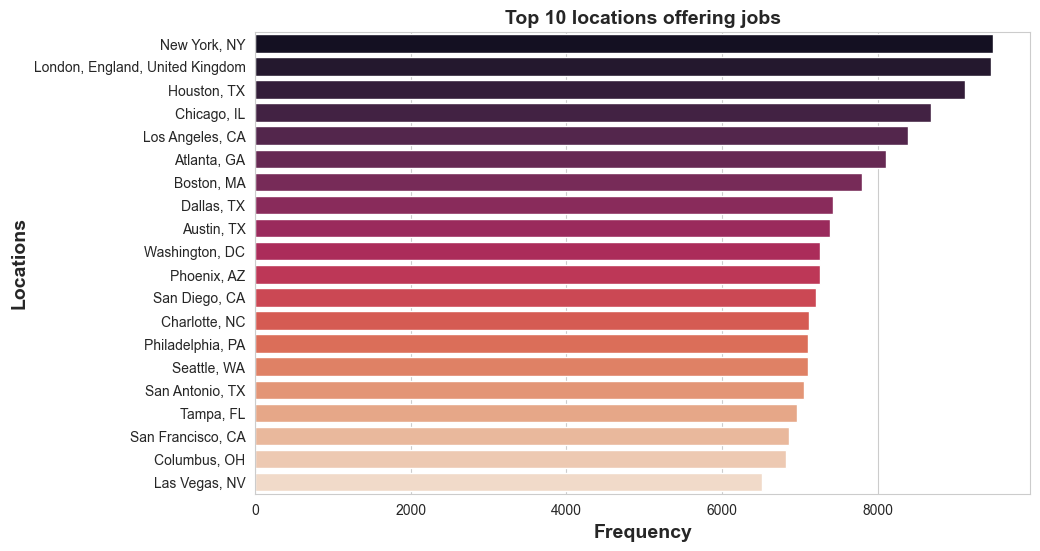

In [20]:
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
sns.barplot(x=count, y=location, palette='rocket',hue=location)
plt.title('Top 10 locations offering jobs', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel('Frequency', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.ylabel('Locations', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.show()

In [17]:
pipeline = [{
    "$group": {
        "_id": "$search_city",
        "count": {"$sum": 1}
    }},
    {"$sort": {'count': -1}},
    {"$limit": 20}]

result = list(my_col.aggregate(pipeline))

city = [rec['_id'] for rec in result]
count = [rec['count'] for rec in result]

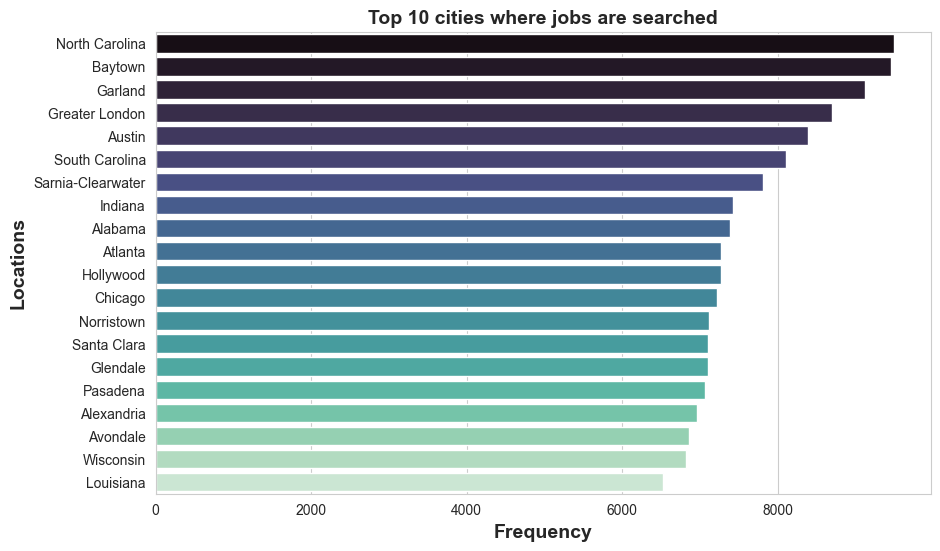

In [ ]:
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
sns.barplot(x=count, y=city, palette='mako',hue=city)
plt.title('Top 10 locations where jobs are searched', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel('Frequency', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.ylabel('Locations', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.show()

In [9]:
pipeline = [{
    "$group": {
        "_id": "$search_country",
        "count": {"$sum": 1}
    }},
    {"$sort": {'count': -1}},
    {"$limit": 20}]

result = list(my_col.aggregate(pipeline))

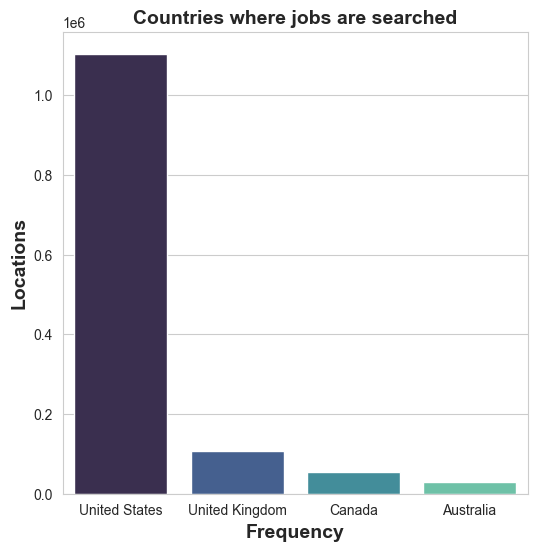

In [ ]:
country = [rec['_id'] for rec in result]
count = [rec['count'] for rec in result]

plt.figure(figsize=(6,6))
sns.set_style("whitegrid")
sns.barplot(x=country, y=count, palette='mako',hue=country)
plt.title('Countries where jobs are searched', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel('Countries', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.ylabel('Frequency', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.show()

In [16]:
pipeline = [{
    "$group": {
        "_id": "$job_level",
        "count": {"$sum": 1}
    }},
    {"$sort": {'count': -1}},
    {"$limit": 20}]

result = list(my_col.aggregate(pipeline))

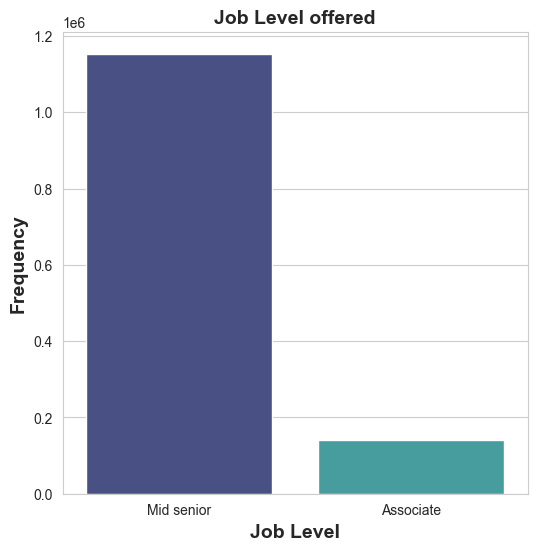

In [19]:
level = [rec['_id'] for rec in result]
count = [rec['count'] for rec in result]

plt.figure(figsize=(6,6))
sns.set_style("whitegrid")
sns.barplot(x=level, y=count, palette='mako',hue=level)
plt.title('Job Level offered', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel('Job Level', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.ylabel('Frequency', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.show()

In [20]:
pipeline = [{
    "$group": {
        "_id": "$job_type",
        "count": {"$sum": 1}
    }},
    {"$sort": {'count': -1}},
    {"$limit": 20}]

result = list(my_col.aggregate(pipeline))

job = [rec['_id'] for rec in result]
count = [rec['count'] for rec in result]

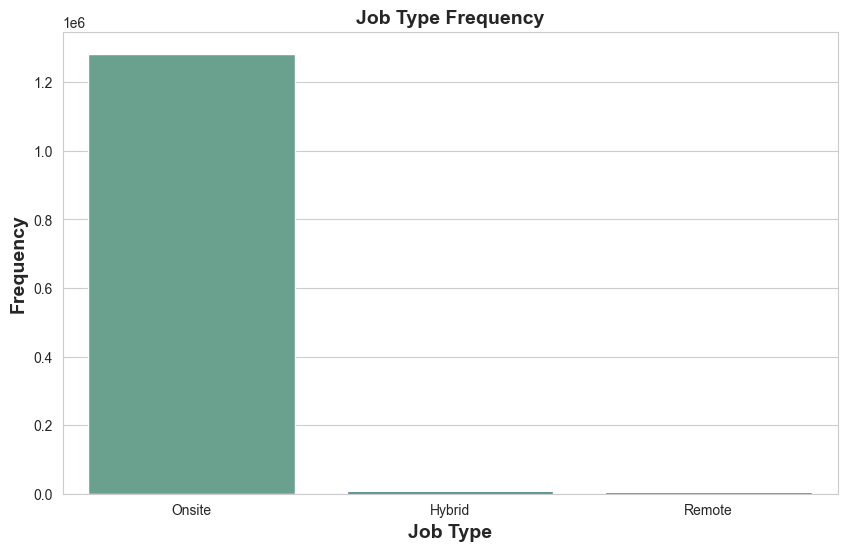

In [24]:
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
sns.barplot(x=job, y=count, palette='crest',hue=job)
plt.title('Job Type Frequency', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel('Job Type', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.ylabel('Frequency', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.show()

In [13]:
pipeline = [{
    "$group": {
        "_id": "$search_position",
        "count": {"$sum": 1}
    }},
    {"$sort": {'count': -1}},
    {"$limit": 20}]

result = list(my_col.aggregate(pipeline))

position = [rec['_id'] for rec in result]
count = [rec['count'] for rec in result]

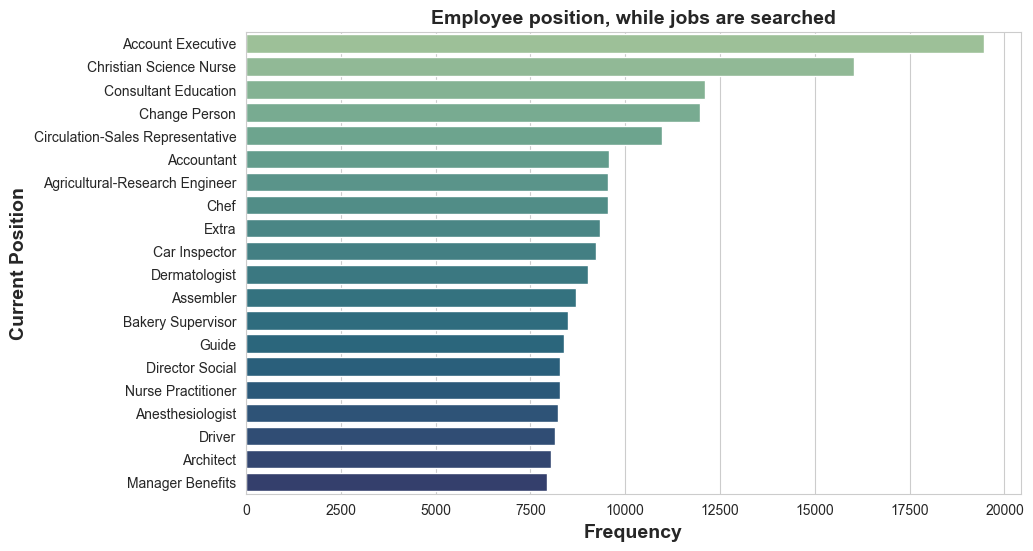

In [15]:
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
sns.barplot(x=count, y=position, palette='crest',hue=position)
plt.title('Employee position, while jobs are searched', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel('Frequency', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.ylabel('Current Position', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.show()

## Transforming Job Summary and Job skills field

Removing html tags such as \n, \t etc and texts like Show more, Show less and etc which gets fetched while scraping data

In [10]:
# user defined function to clean the summary

def clean_summary(summary):
    if not summary:
        return summary
    summary = re.sub(r'\s+', ' ', summary)  # Replaces multiple whitespaces/newlines with single space
    summary = re.sub(r'Show more\s*Show less', '', summary, flags=re.IGNORECASE)
    summary = re.sub(r'\b(Apply now|birdjobs|read more)\b', '', summary, flags=re.IGNORECASE)
    return summary.strip()

In [ ]:
# updating job summary fields in all documents

all_records = my_col.find({}, {'_id': 1, "job_summary": 1})

for rec in all_records:
    summary = rec.get("job_summary", "")
    cleaned_summary = clean_summary(summary)
    my_col.update_one({'_id': rec["_id"]}, {"$set": {"job_summary": cleaned_summary}})

Checking the summary to ensure changes

In [16]:
sample = my_col.aggregate([{"$sample": {"size": 5}}])

for rec in sample:
    pprint(rec['job_summary'])

('Job Details Description Arisa Health is seeking candidates for a Clinical '
 'Manager position in our Springdale and Bentonville Child Outpatient clinics. '
 "A master's degree in Counseling or Social Work with a current terminal "
 'Arkansas license (LPC or LCSW) is required. The candidate should have '
 'excellent communication (oral and written), time management, organizational, '
 'computer (including Excel) and leadership skills. At least two years of '
 'experience working with clients in a mental health setting is required. The '
 'ability to be self-motivated, organized and to work independently as well as '
 'with a treatment team model is required, along with the ability to work '
 'within school settings. Candidates should have the ability to organize and '
 'prioritize and be patient, consistent, and flexible. We prefer at least two '
 'years of management experience. The Clinical Manager will support our Mental '
 'Health Professionals in the Springdale and the Bentonvil

Job Summary has been cleaned

Checking sample Job skills data

In [26]:
sample = my_col.aggregate([{"$sample": {"size": 2}}])

print("Job Skills samples")
for rec in sample:
    print(rec['job_skills'])
    print(type(rec['job_skills']))
    print('*' * 30)

Job Skills samples
Retail management, Customer service, Sales strategies, Store operations, Hiring, Training, Performance evaluations, Compliance, Communication, Data analysis, Problem solving, Flexibility, High school diploma, 3+ years retail management, Strong interpersonal skills, Leadership, Motivation, Problem solving, Flexibility, Ability to stand for long periods, Ability to work weekends and holidays, Accountability, Attention to detail, Follow up, Follow through, Medical insurance, Dental insurance, Vision insurance, Life insurance, 401(k), Paid holidays, PTO policy, Companyprovided equipment, Remote work
<class 'str'>
******************************
Bachelor's degree, Human services, Developmental disabilities, Residential or day program setting, Managing and supervising services, Decisionmaking, Time management, Communication skills, Incident reports/investigations, Site reviews/audits, Compliance, Regulations, Medication documentation, Training, Program Director, Area direct

In [42]:
# function to convert comma separated str skills to list of skills

def skills(job_skill):
    return job_skill.lower().strip().split(',')

In [43]:
# Applyting the function 

for rec in my_col.find({}):
    job_skill = rec['job_skills']
    my_col.update_one({'_id': rec['_id']}, {'$set': {'job_skills': skills(job_skill)}})

In [29]:
pipeline = [{
    "$group": {
        "_id": "$job_location",
        "count": {"$sum": 1}
    }},
    {"$sort": {'count': -1}}]

result = my_col.aggregate(pipeline)

In [31]:
location = list(result)
location_names = [rec['_id'] for rec in location]
location_names[:5]

['New York, NY',
 'London, England, United Kingdom',
 'Houston, TX',
 'Chicago, IL',
 'Los Angeles, CA']

Job skills field is now list of skills

## Geo Visualization

### Using Nominatim to fetch latitude longitude information of each location

In [ ]:
geolocator = Nominatim(user_agent='Sandip')
cache_file = "location_cache.json"

if os.path.exists(cache_file):
    with open(cache_file, 'r') as file:
        location_cache = json.load(file)
else:
    location_cache = {}

def geocode_location(location):
    try:
        loc = geolocator.geocode(location)
        if loc:
            return {"latitude": loc.latitude, "longitude": loc.longitude}
    except Exception as e:
        print(f"Error: {e}")
    return {"latitude": None, "longitude": None}

for i, loc in enumerate(location_names):
    if loc not in location_cache:
        coords = geocode_location(loc)
        location_cache[loc] = coords
        print(f"{i+1} out of 28776 | {loc} -> {coords}")
        time.sleep(1) #Nominatim allows only 1 fetch per second

    # saving progress -> every 100th time
    if i % 100 == 0:
        with open(cache_file, 'w') as file:
            json.dump(location_cache, file, indent=2)

# final save -> precaution

with open(cache_file, 'w') as file:
    json.dump(location_cache, file, indent=2)

print("All locations processed and saved")

1 out of 28776 | New York, NY -> {'latitude': 40.7127281, 'longitude': -74.0060152}
2 out of 28776 | London, England, United Kingdom -> {'latitude': 51.5074456, 'longitude': -0.1277653}
3 out of 28776 | Houston, TX -> {'latitude': 29.7589382, 'longitude': -95.3676974}
Error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Chicago%2C+IL&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
4 out of 28776 | Chicago, IL -> {'latitude': None, 'longitude': None}
5 out of 28776 | Los Angeles, CA -> {'latitude': 34.3155072, 'longitude': -118.209681}
6 out of 28776 | Atlanta, GA -> {'latitude': 33.7489924, 'longitude': -84.3902644}
7 out of 28776 | Boston, MA -> {'latitude': 42.3554334, 'longitude': -71.060511}
8 out of 28776 | Dallas, TX -> {'latitude': 32.7762719, 'longitude': -96.7968559}
9 out of 28776 | Austin, TX -> {'latitude': 30.

In [41]:
# update a new field job_location_coords which will have the coordinates of the Job location

with open("location_cache.json", 'r') as file:
    location_cache = json.load(file)

for doc in my_col.find():
    loc_name = doc.get("job_location")
    coords = location_cache.get(loc_name)
    if coords:
        my_col.update_one({'_id': doc['_id']}, {"$set": {"job_location_coords": coords}})

print("All documents updated with job location coordinates")
  

All documents updated with job location coordinates


In [ ]:
# Randomly checking 2 locations and their coordinates

sample = my_col.aggregate([{'$sample': {'size': 3}}])

for rec in sample:
    print(rec['job_location'])
    print(rec['job_location_coords'])

Liverpool, England, United Kingdom
{'latitude': 53.4071991, 'longitude': -2.99168}
Maidstone, England, United Kingdom
{'latitude': 51.2748258, 'longitude': 0.5231646}
Aventura, FL
{'latitude': 25.9564812, 'longitude': -80.1392121}


### Creating an interactive visualization of a subset of data

In [ ]:
# Convert cursor to list and sample 1% (13,000)
all_jobs = list(my_col.find())
sample_size = int(len(all_jobs) * 0.01)
sample_jobs = random.sample(all_jobs, sample_size)

# Initialize map
m = folium.Map(location=[20, 0], zoom_start=2.2, tiles="CartoDB positron")
marker_cluster = MarkerCluster().add_to(m)

# Add markers for sampled jobs
for job in sample_jobs:
    coords = job.get('job_location_coords', {})
    lat = coords.get('latitude')
    lon = coords.get('longitude')

    if lat and lon:
        popup_text = f"""
        <b>{job.get('job_title', 'N/A')}</b><br>
        <i>{job.get('company', 'Unknown')}</i><br>
        {job.get('location')}
        """
        folium.Marker(
            location=[lat, lon],
            popup=folium.Popup(popup_text, max_width=250),
            icon=folium.Icon(color='blue', icon='briefcase', prefix='fa')
        ).add_to(marker_cluster)

# Saving the map
m.save("sampled_global_job_map.html")
print("Sampled map saved as sampled_global_job_map.html")


Sampled map saved as sampled_global_job_map.html


### Using Geopandas to do visualization of all job locations

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Convert MongoDB to DataFrame
data = list(my_col.find({}, {'job_location_coords.latitude': 1, 'job_location_coords.longitude': 1}))
df = pd.DataFrame(data)

df.head()

_id                                job_location_coords
0  67f3f53756f048df5c3e52f1  {'latitude': 32.7169643, 'longitude': -117.170...
1  67f3f53756f048df5c3e52f2  {'latitude': 43.1689044, 'longitude': -86.2639...
2  67f3f53756f048df5c3e52f3  {'latitude': 40.5710454, 'longitude': -111.895...
3  67f3f53756f048df5c3e52f4  {'latitude': 40.8853773, 'longitude': -73.9523...
4  67f3f53756f048df5c3e52f5  {'latitude': 43.2341813, 'longitude': -86.2483...

In [9]:
# Extract latitude and longitude from the dictionary column
df['latitude'] = df['job_location_coords'].apply(lambda x: x.get('latitude') if isinstance(x, dict) else None)
df['longitude'] = df['job_location_coords'].apply(lambda x: x.get('longitude') if isinstance(x, dict) else None)


In [ ]:
# Drop rows with missing or invalid coordinates
df = df.dropna(subset=['latitude', 'longitude'])

# Remove rows where coordinates are not within valid bounds
df = df[(df['latitude'].between(-90, 90)) & (df['longitude'].between(-180, 180))]

Creating Geometies

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# Create Point geometries from lat/lon
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Set coordinate reference system (CRS) to WGS84 (lat/lon)
gdf.set_crs(epsg=4326, inplace=True)

_id  \
0        67f3f53756f048df5c3e52f1   
1        67f3f53756f048df5c3e52f2   
2        67f3f53756f048df5c3e52f3   
3        67f3f53756f048df5c3e52f4   
4        67f3f53756f048df5c3e52f5   
...                           ...   
1294263  67f3f54056f048df5c5212a8   
1294264  67f3f54056f048df5c5212a9   
1294265  67f3f54056f048df5c5212aa   
1294266  67f3f54056f048df5c5212ab   
1294267  67f3f54056f048df5c5212ac   

                                       job_location_coords   latitude  \
0        {'latitude': 32.7169643, 'longitude': -117.170...  32.716964   
1        {'latitude': 43.1689044, 'longitude': -86.2639...  43.168904   
2        {'latitude': 40.5710454, 'longitude': -111.895...  40.571045   
3        {'latitude': 40.8853773, 'longitude': -73.9523...  40.885377   
4        {'latitude': 43.2341813, 'longitude': -86.2483...  43.234181   
...                                                    ...        ...   
1294263  {'latitude': 41.8239891, 'longitude': -71.4128...  41.823989   
1294264  {'latitude': 30.0035365, 'longitude': -91.8187...  30.003536   
1294265  {'latitude': 40.9168692, 'longitude': -72.6624...  40.916869   
1294266  {'latitude': 39.7405111, 'longitude': -104.830...  39.740511   
1294267  {'latitude': 34.0278787, 'longitude': -118.388...  34.027879   

          longitude                     geometry  
0       -117.170067  POINT (-117.17007 32.71696)  
1        -86.263946    POINT (-86.26395 43.1689)  
2       -111.895381  POINT (-111.89538 40.57105)  
3        -73.952360   POINT (-73.95236 40.88538)  
4        -86.248392   POINT (-86.24839 43.23418)  
...             ...                          ...  
1294263  -71.412834   POINT (-71.41283 41.82399)  
1294264  -91.818729   POINT (-91.81873 30.00354)  
1294265  -72.662419   POINT (-72.66242 40.91687)  
1294266 -104.830994  POINT (-104.83099 39.74051)  
1294267 -118.388849  POINT (-118.38885 34.02788)  

[1267641 rows x 5 columns]

Visualization

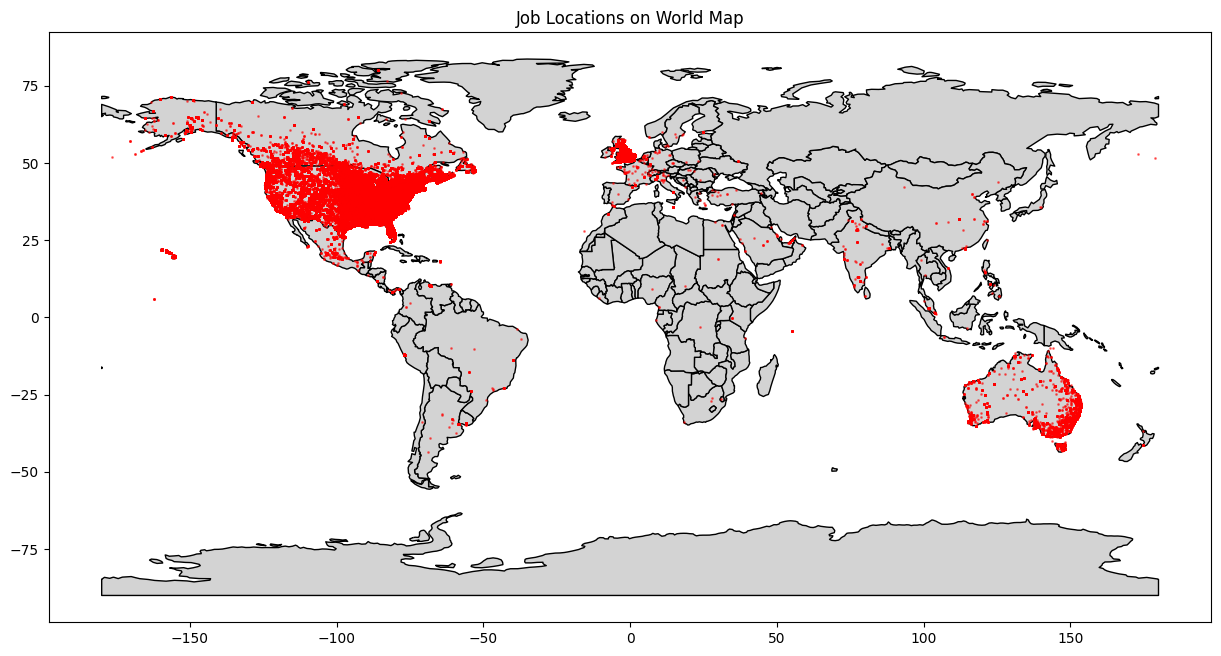

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Read shapefile (change path if needed)
world = gpd.read_file("../ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")

# Plot world and job locations
fig, ax = plt.subplots(figsize=(15, 10))
world.plot(ax=ax, color='lightgray', edgecolor='black')
gdf.plot(ax=ax, markersize=1, color='red', alpha=0.5)

plt.title("Job Locations on World Map")
plt.show()

## Most frequent key words in Job summary

In [ ]:
import spacy
import re
from nltk.corpus import stopwords

Creating list of tokens (words) using en_core_web_sm model provided by spacy module

In [10]:
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english')) 

def clean_tokens(text):
    # remove numbers and transform to lowercase
    text = re.sub(r'[^a-zA-Z]', ' ', text.lower()) 
    doc = nlp(text)

    tokens = [token.lemma_ for token in doc if token.lemma_ not in stop_words and not token.is_stop and len(token)>2]

    return tokens

In [11]:
# try it on 1 doc

doc = my_col.find_one({})
summary = doc.get("job_summary", "")

transformed = clean_tokens(summary)

print(f"Original: ", summary)
print(f"Processed: ", transformed)

Original:  Responsibilities Job Description Summary Job Description We are the makers of possible BD is one of the largest global medical technology companies in the world. Advancing the world of health™ is our Purpose, and it’s no small feat. It takes the imagination and passion of all of us—from design and engineering to the manufacturing and marketing of our billions of MedTech products per year—to look at the impossible and find transformative solutions that turn dreams into possibilities. We believe that the human element, across our global teams, is what allows us to continually evolve. Join us and discover an environment in which you’ll be supported to learn, grow and become your best self. Become a maker of possible with us. Job Title: Account Executive- Acute Care Territory: Northern California, Northern Nevada - Must live in the geographical ar Summary The Account Executive is responsible for driving sales and services to new and existing customers. They are responsible for m

In [ ]:
# Update all documents with a new field - job_summary_tokens

for doc in my_col.find({}):
    summary = doc.get("job_summary", "")
    transformed = clean_tokens(summary)

    my_col.update_one({'_id': doc['_id']}, {'$set': {'job_summary_tokens': transformed}}) # commented out to prevent rerun

In [8]:
# fetch tokens

tokens = my_col.find({'job_summary_tokens': {"$exists": True}}, {'job_summary_tokens': 1, '_id': 0})

token_list = [doc['job_summary_tokens'] for doc in tokens]
token_list[0]

['responsibility',
 'job',
 'description',
 'summary',
 'job',
 'description',
 'maker',
 'possible',
 'large',
 'global',
 'medical',
 'technology',
 'company',
 'world',
 'advance',
 'world',
 'health',
 'purpose',
 'small',
 'feat',
 'take',
 'imagination',
 'passion',
 'design',
 'engineering',
 'manufacturing',
 'marketing',
 'billion',
 'medtech',
 'product',
 'year',
 'look',
 'impossible',
 'find',
 'transformative',
 'solution',
 'turn',
 'dream',
 'possibility',
 'believe',
 'human',
 'element',
 'global',
 'team',
 'allow',
 'continually',
 'evolve',
 'join',
 'discover',
 'environment',
 'support',
 'learn',
 'grow',
 'good',
 'self',
 'maker',
 'possible',
 'job',
 'title',
 'account',
 'executive',
 'acute',
 'care',
 'territory',
 'northern',
 'california',
 'northern',
 'nevada',
 'live',
 'geographical',
 'summary',
 'account',
 'executive',
 'responsible',
 'drive',
 'sale',
 'service',
 'new',
 'exist',
 'customer',
 'responsible',
 'maximize',
 'customer',
 'value',

In [11]:
dictionary = corpora.Dictionary(token_list)

In [18]:
dictionary.filter_extremes(no_below=10, no_above=0.5) # remove extreme words

In [25]:
corpus = [dictionary.doc2bow(text) for text in token_list]

LDA topic modeling categorizes job listings into themes like Pay, Healthcare, and Business.

In [26]:
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,             
    random_state=42,
    passes=10,               
    chunksize=1000,
    alpha='auto',
    per_word_topics=True
)

In [ ]:
# Show top 5 words for each topic
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.023*"pay" + 0.013*"insurance" + 0.012*"medical" + 0.012*"hour" + 0.011*"healthcare"')
(1, '0.024*"status" + 0.018*"disability" + 0.018*"employment" + 0.016*"gender" + 0.014*"protect"')
(2, '0.039*"care" + 0.038*"patient" + 0.020*"health" + 0.014*"nursing" + 0.012*"clinical"')
(3, '0.015*"client" + 0.010*"manage" + 0.010*"business" + 0.009*"manager" + 0.009*"financial"')
(4, '0.012*"program" + 0.012*"student" + 0.011*"application" + 0.011*"education" + 0.009*"school"')
(5, '0.012*"perform" + 0.010*"safety" + 0.009*"duty" + 0.009*"maintain" + 0.009*"guest"')
(6, '0.033*"des" + 0.026*"les" + 0.011*"pour" + 0.010*"une" + 0.010*"vous"')
(7, '0.023*"project" + 0.014*"system" + 0.011*"design" + 0.010*"engineering" + 0.009*"technical"')
(8, '0.011*"role" + 0.009*"customer" + 0.009*"people" + 0.009*"business" + 0.008*"build"')
(9, '0.057*"store" + 0.044*"customer" + 0.024*"sale" + 0.020*"merchandise" + 0.017*"manager"')


## Word Cloud for Job skills

In [29]:
for doc in my_col.find({}, {'job_skills': 1}).limit(5):
    print(doc)

{'_id': ObjectId('67f3f53756f048df5c3e52f1'), 'job_skills': ['medical equipment sales', ' key competitors', ' terminology', ' technology', ' trends', ' challenges', ' reimbursement', ' government regulation', ' bd offerings', ' pipeline management', ' opportunity planning', ' solution sales process', ' customer relationships', ' collaboration', ' negotiation', ' internal and external customer satisfaction', ' trust building', ' sales opportunities', ' new solution introduction', ' pharmacy', ' it', ' nursing', ' csuite', " bachelor's degree", ' travel', " driver's license"]}
{'_id': ObjectId('67f3f53756f048df5c3e52f2'), 'job_skills': ['nursing', ' bachelor of science in nursing', ' masters degree in nursing', ' care management experience', ' clinical experience in nursing', ' licensure to practice nursing in michigan', ' population management', ' selfmanagement', ' education', ' oversight of registries', ' patient education', ' patient selfmanagement', ' patient care coordination', ' c

In [38]:
skill_counter = Counter()

for doc in my_col.find({}, {"job_skills": 1}):
    skill_counter.update(doc["job_skills"])

top_skills = [skill for skill, i in skill_counter.most_common(500)]

In [42]:
import pickle

with open('saved/top_skills.pkl', 'wb') as file:
    pickle.dump(top_skills, file)

In [46]:
with open('saved/skill_counter.pkl', 'wb') as file:
    pickle.dump(skill_counter, file)

In [2]:
import pickle
with open('saved/top_skills.pkl', 'rb') as file:
    top_skills = pickle.load(file)

print(top_skills)

[' communication', ' teamwork', ' customer service', ' communication skills', ' leadership', ' problem solving', ' time management', ' attention to detail', ' problemsolving', ' project management', ' interpersonal skills', ' patient care', ' collaboration', ' training', 'customer service', ' data analysis', ' organizational skills', ' microsoft office suite', ' inventory management', ' sales', ' high school diploma', ' scheduling', " bachelor's degree", ' multitasking', 'nursing', ' analytical skills', ' adaptability', ' flexibility', ' microsoft office', ' critical thinking', ' documentation', ' organization', ' safety', ' budgeting', ' troubleshooting', ' problemsolving skills', ' written communication', ' conflict resolution', ' excel', ' coaching', ' paid time off', ' verbal communication', ' life insurance', ' supervision', ' reporting', ' quality control', ' merchandising', ' decision making', ' computer skills', ' travel', ' quality assurance', ' team management', ' research', 

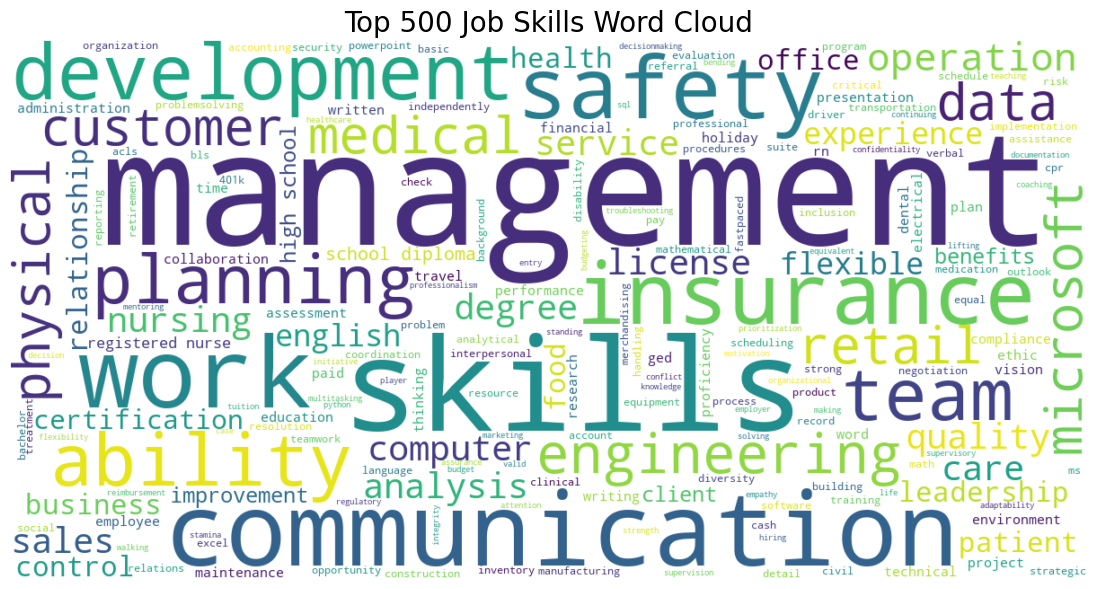

In [5]:
text = ' '.join(top_skills)
wordcloud = WordCloud(width=1200, height=600, background_color='white', colormap='viridis').generate(text)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top 500 Job Skills Word Cloud", fontsize=20)
plt.show()